In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
driveDir='/content/drive/MyDrive/imageCaptioning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!ls -1 /content/drive/MyDrive/imageCaptioning/rawData/instagram_data/img/  | wc -l

In [ ]:
#!unzip /content/drive/MyDrive/imageCaptioning/archive.zip -d /content/drive/MyDrive/imageCaptioning/rawData/

In [ ]:
#!pip install tensorflow==2.0.0-rc0
#!pip install tqdm
from nltk.translate.bleu_score import sentence_bleu
import string
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.pyplot as plt
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import csv
from wordcloud import WordCloud
import pandas as pd
%matplotlib inline

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [ ]:
dataCsvPath=driveDir+"rawData/instagram_data/captions_csv.csv"
df = pd.read_csv(dataCsvPath)
df.head()

,Sr No,Image File,Caption
0,1,img/insta1,NaN
1,2,img/insta2,bye
2,3,img/insta3,"Ok, a few more... sorry I just had so much fun..."
3,4,img/insta4,This was one of my favorite shoots I’ve ever d...
4,5,img/insta5,Wrapped round my finger like a ring


In [ ]:
def captionMap(df):
  dict={}
  for index, row in df.iterrows():
  #print(type(row['Caption']))
    if type(row['Caption']) is not float  and len(row['Caption']) <500:
      if len(row['Caption']) in dict:
        dict[len(row['Caption'])]=dict[len(row['Caption'])]+1

      else:
       dict[len(row['Caption'])]=1


  lists = sorted(dict.items()) # sorted by key, return a list of tuples

  x, y = zip(*lists) # unpack a list of pairs into two tuples

  plt.plot(x, y)
  plt.show()


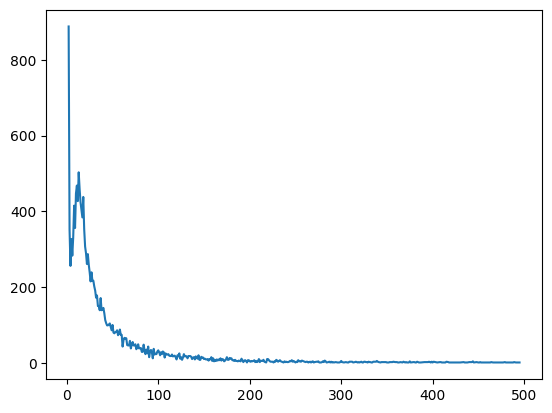

In [ ]:
captionMap(df)

In [ ]:
def remove_emoji(string):

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    string=emoji_pattern.sub(r'', string) # no emoji

    y = " ".join(string.split())# extra space
    #y = re.sub(r'(!|.)1+', '', y)
    y=y.lower()
    y = re.sub(r'i love you|i love|love you|love', '', y)
    y = re.sub(r'💙|💋|😊|🇬🇧|😜|😡|🔥|👍|😍|💚', '', y)


    return y
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)


In [ ]:
def text_clean(text_original):
   text = remove_emoji(text_original)
   text = remove_punctuation(text)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

In [ ]:
all_captions = []
all_img_name_vector = []


with open(dataCsvPath, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        y=text_clean(row[2])
        #print(y)
        if((len(y)>150 or len(y)<20) or y==""  or not os.path.isfile(driveDir+"rawData/instagram_data/"+row[1]+".jpg")):
          continue
        #print(row[1],row[2])
        all_img_name_vector.append(driveDir+"rawData/instagram_data/"+row[1]+".jpg")

        all_captions.append('<start> '+y+' <end>')

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

len(train_captions), len(img_name_vector)

(5003, 5003)

In [ ]:
random.sample(train_captions, 5)


['<start>  complex was on one cover side kanye on the other <end>',
 '<start>  is check out the website now <end>',
 '<start>  in complete anthony mandler and thank you for my first moon <end>',
 '<start>  congrats great show <end>',
 '<start>  you were amazing miss you so australia next see you tomorrow night been way too ps hometown better scream loud for them <end>']

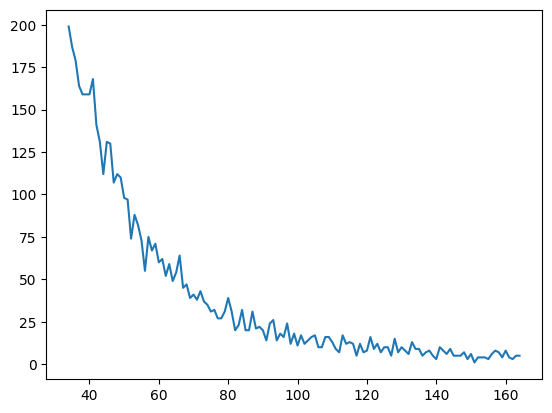

In [ ]:
captionMap(pd.DataFrame(train_captions,columns =['Caption']))

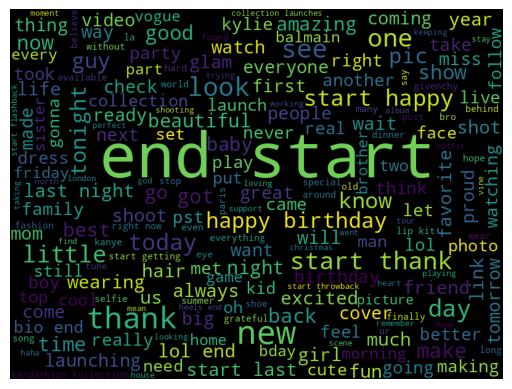

In [ ]:
wordcloud = WordCloud(width=800, height=600).generate(str(' '.join(train_captions)))

# Display or save the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file(driveDir+"wordcloud_3.png")

In [ ]:
def load_image(image_path):
    #print(image_path)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    #print(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:


encode_train = sorted(set(img_name_vector))
print(len(encode_train))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
print(image_dataset)

image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8)
#image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
print(image_dataset)



5003
<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    #print(path)
    #print(os.path.isfile(path+".npy"))
    #if os.path.isfile(path+".npy"):
      #continue

    batch_features = image_features_extract_model(img)
    #print(batch_features.shape[:])
    #print(batch_features.shape[0])
    #print(batch_features)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    #print(batch_features)
    for bf, p in zip(batch_features, path) :
        #if driveDir+"rawData/instagram_data/"+row[1]+".jpg"

        path_of_feature = p.numpy().decode("utf-8")
        #if os.path.isfile(path_of_feature+".npy"):
          #continue
         #print(path_of_feature)
        #print("----",path_of_feature)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 1326/1326 [15:25<00:00,  1.43it/s]


In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ♪')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# saving
with open(driveDir+'tokenizer_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)
print(max_length)
BATCH_SIZE = 32

34


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector,test_size=0.03,random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(4852, 4852, 151, 151)

In [ ]:
img_name_train=img_name_train[:int(len(img_name_train)/BATCH_SIZE)]
cap_train=cap_train[:int(len(img_name_train)/BATCH_SIZE)]
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(4832, 4832, 151, 151)

In [ ]:

BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
num_steps = len(img_name_train) // BATCH_SIZE

num_steps

5391


151

In [ ]:
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  #print(img_name.decode('utf-8'))
  if not os.path.isfile(img_name.decode('utf-8')+'.npy'):
    print("notfound",img_name.decode('utf-8')+'.npy')
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1 )

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

In [ ]:
with tf.device('/GPU:0'):
  @tf.function
  def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [ ]:
checkpoint_path = driveDir+"checkpoint_4/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=500)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  print(int(ckpt_manager.latest_checkpoint.split('-')[-1]))
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
start_epoch



40


40

In [ ]:
EPOCHS = 50
with tf.device('/GPU:0'):
  for epoch in range(start_epoch, EPOCHS):
      start = time.time()
      total_loss = 0

      for (batch, (img_tensor, target)) in enumerate(dataset):
          #print(batch,end='\r')
          #print(target)
          batch_loss, t_loss = train_step(img_tensor, target)
          total_loss += t_loss

          if batch % 1000 == 0:
              print ('Epoch {} Batch {} Loss {:.4f} time {}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]),time.time() - start))
    # storing the epoch end loss value to plot later
      loss_plot.append(total_loss / num_steps)

      #if epoch % 2 == 0:
      ckpt_manager.save()

      print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 11 Batch 0 Loss 0.8504 time 2.4474539756774902
Epoch 11 Loss 0.772324
Time taken for 1 epoch 14.258006811141968 sec

Epoch 12 Batch 0 Loss 0.5883 time 2.311401605606079
Epoch 12 Loss 0.677589
Time taken for 1 epoch 13.956367254257202 sec

Epoch 13 Batch 0 Loss 0.5469 time 2.3104777336120605
Epoch 13 Loss 0.593099
Time taken for 1 epoch 13.961581707000732 sec

Epoch 14 Batch 0 Loss 0.5629 time 2.3348958492279053
Epoch 14 Loss 0.514097
Time taken for 1 epoch 14.41432785987854 sec

Epoch 15 Batch 0 Loss 0.5549 time 2.5232293605804443
Epoch 15 Loss 0.444001
Time taken for 1 epoch 15.451878070831299 sec

Epoch 16 Batch 0 Loss 0.3515 time 2.635126829147339
Epoch 16 Loss 0.374679
Time taken for 1 epoch 14.936965227127075 sec

Epoch 17 Batch 0 Loss 0.2523 time 2.6143977642059326
Epoch 17 Loss 0.320383
Time taken for 1 epoch 15.029942750930786 sec

Epoch 18 Batch 0 Loss 0.2906 time 2.6489553451538086
Epoch 18 Loss 0.278102
Time taken for 1 epoch 14.694997787475586 sec

Epoch 19 Batch 0 Lo

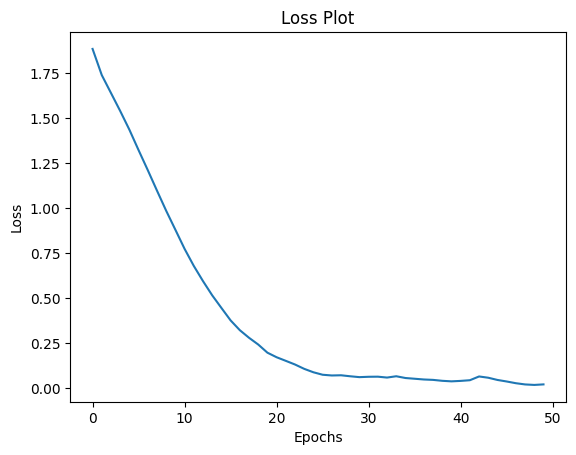

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
#loss_plot
# <tf.Tensor: shape=(), dtype=float32, numpy=0.0058856406>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.005761345>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.005330383>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.005410546>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.004999651>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.0050686463>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.005238437>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.0050754915>,
# <tf.Tensor: shape=(), dtype=float32, numpy=0.0050553293>]

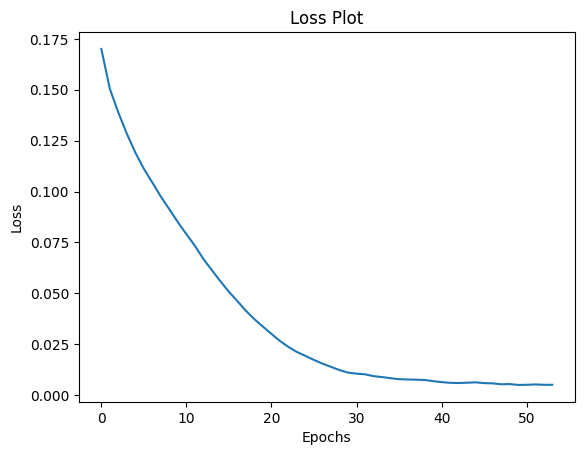

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))
#ckpt.restore((checkpoint_path+"ckpt-30"))

In [ ]:
ckpt.encoder.summary()
ckpt.decoder.attention.summary()
ckpt.optimizer.get_config()

Model: "cnn__encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  524544    
                                                                 
Total params: 524544 (2.00 MB)
Trainable params: 524544 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "bahdanau_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  131584    
                                                                 
 dense_4 (Dense)             multiple                  262656    
                                                                 
 dense_5 (Dense)             multiple                  513       
                                                        

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': False,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    #print(img_tensor_val)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
def postProcessData(text):
  t=[]
  for i in text:
    #print(i)
    if i.strip()  != "<end>" and  i.strip()  != "<start>" and i.strip()  != "<pad>":
      t.append(i)
  #text = re.sub(r'<pad>|<start>|<end>', '', " ".join(text))
  return t

In [ ]:
def result(t,realCaption,printCond):
  #print(t)
  image_path = t
  result, attention_plot = evaluate(image_path)
  if printCond:
    print ('Prediction Caption:', ' '.join(postProcessData(result)))
  realAppn=[]
  realCaption=tokenizer.sequences_to_texts(realCaption)
  realCaption = re.sub(r'<pad>|<start>|<end>', '', " ".join(realCaption))
  if printCond:
    print("Real Caption:",realCaption)
#plot_attention(image_path, result, attention_plot)
# opening the image
# reading the image
  realAppn.append(realCaption.split())
  references = realAppn



  score1= sentence_bleu(references,result, weights=(1.0,0,0,0))

  if printCond:
    print(f"Bleu score: {score1*100}")

  testImage = img.imread(image_path)

# displaying the image
  if printCond:
    plt.imshow(testImage)
#Image.open(image_path)
  return score1

Prediction Caption: she her valentine one
Real Caption:  she her valentine day                             
Bleu 1 score: 60.0


0.6

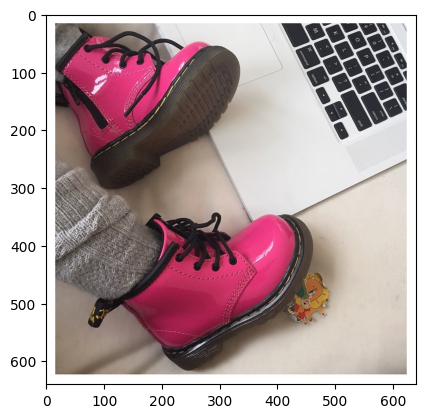

In [ ]:
result(img_name_val[0],cap_val[0:1],True)

Prediction Caption: get ready for all new chillin of london up with the chandler on
Real Caption:  get ready for all new episode of keeping up with the kardashisns on                    
Bleu 1 score: 71.42857142857143


0.7142857142857143

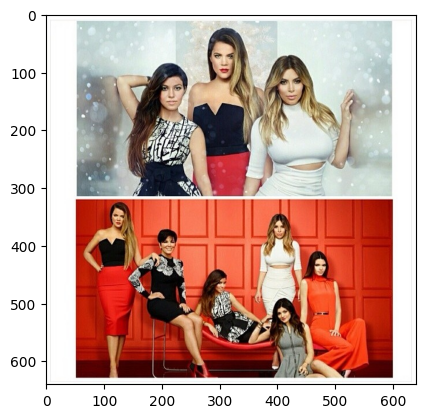

In [ ]:
result(img_name_val[31],cap_val[31:32],True)

In [ ]:
s1=0
for i in range(0,len(img_name_val)):
  s1i=result(img_name_val[i],cap_val[i:i+1],False)
  s1+=s1i

In [ ]:
print(f"Test Bleu score: {s1/len(img_name_val)*100}")

Test Bleu score: 61.98137569923401
